# Between Ghosts and Graphs:   
## A Data-Driven reading of The Canterville Ghost.

*Resumen*  

Este proyecto explora la posibilidad de analizar un texto literario mediante metodologías propias del análisis de datos, tomando como caso de estudio The Canterville Ghost de Oscar Wilde (1887). A partir del procesamiento del texto y su modelado en estructuras de datos, el análisis se desarrolla en tres ejes principales: estilo, temática y tono afectivo.

Mediante técnicas de conteo léxico, análisis estructural, diccionarios temáticos, análisis de polaridad léxica y visualizaciones exploratorias, se identifican patrones narrativos que evidencian la alternancia estilística, la superposición de registros góticos, cómicos y culturales, así como una predominante neutralidad afectiva asociada a la ironía característica del autor.

Los resultados demuestran que el análisis de datos no sustituye la interpretación literaria, sino que la complementa, ofreciendo nuevas perspectivas para observar la estructura, el ritmo y las relaciones narrativas del texto. Este enfoque se inscribe dentro de las humanidades digitales y pone de relieve el potencial de las metodologías computacionales para el estudio de la literatura.

*Importación de librerías*

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import networkx as nx
import itertools
from collections import Counter
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.patches as mpatches




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\titan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\titan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Declaración de funciones

Función que clasifica el tipo de interacción

In [39]:
def classifyInteraction(sentence):
    s = sentence.strip().lower()
    
    if sentence.strip().startswith('"') or sentence.strip().startswith("—"):
        return "dialogue"

    elif sentence.isupper() or re.search(r"beware|counterfeite", s):
        return "written_text"
   
    elif "sir simon" in s:
        return "sir_simon"
    
    elif "ghost" in s and re.search(r"laughed|groan|appeared|haunt|fled|vanished|chains", s):
        return "ghost_action"
  
    elif "ghost" in s:
        return "ghost_mention"
    
    else:
        return "narration"

Función que realiza una lista de personajes dentro de la frase

In [40]:
def find_characters(sentence, dictionary):
    s = sentence.lower()
    found = []
    for char, variants in dictionary.items():
        for v in variants:
            if v in s:
                found.append(char)
                break  
    return found if found else None

Función para saber si es o no mencionado sir simon( el fantasma)

In [41]:
def contains_sir_simon(char_list):
    return 'sir_simon' in char_list if isinstance(char_list, list) else False

Función para el conteo de palabras por tema

In [42]:
def count_theme_words(text, words):
    s = text.lower()
    return sum(s.count(w) for w in words)



Función para determinar el tema principal de acuerdo al conteo de palabras temáticas  
comparar los conteos

In [43]:
def dominant_theme(row):
    counts = {
        "gothic": row["gothic_count"],
        "comic": row["comic_count"],
        "cultural": row["cultural_count"]
    }
    return max(counts, key=counts.get) if max(counts.values()) > 0 else "none"

Función para categorizar emociones (positiva, negativa, neutral )

In [44]:
def get_emotion(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return "positive"
    elif polarity < -0.1:
        return "negative"
    else:
        return "neutral"

### Diccionarios


- Diccionario de personajes

In [45]:
characters_dict = {
    "mrOtis": ["mr. otis", "hiram b. otis", "minister", "american minister"],
    "mrsOtis": ["mrs. otis", "lucretia r. tappan", "wife"],
    "washington": ["washington otis", "washington"],
    "virginia": ["virginia otis", "virginia", "miss virginia e. otis"],
    "twins": ["the twins", "star and stripes", "boys"],
    "lordCanterville": ["lord canterville"],
    "ladyCanterville": ["lady canterville"],
    "mrsUmney": ["mrs. umney", "housekeeper"],
    "sir_simon": ["sir simon", "ghost", "canterville ghost", "spook", "spectre"],
    "duke": ["duke of cheshire", "young duke"],
    "duchess": ["dowager duchess of bolton"],
    "rector": ["rev. augustus dampier", "rector"],
    "others": ["lady eleanore", "madame de tremouillac", "lord bilton", "lady stutfield"]
}

- Diccionarios temáticos

In [46]:
themes_dictionary = {
    "gothic": [
        "ghost", "spirit", "haunt", "haunted",
    "blood", "chains", "scream", "terror",
    "fear", "death", "dead", "dark", "darkness",
    "shadow", "horror", "curse", "grave", "night",
    "skeleton", "apparition", "phantom", "spectre",
    "coffin", "graveyard", "tomb",
    "blood-stain", "manacles", "gyves",
    "groan", "shriek", "moan",
    "moonlight", "midnight", "nightmare"
    ],
    "comic": [
       "laugh", "laughter", "joke", "smile",
    "trick", "prank", "ridiculous", "funny",
    "humor", "tease", "play", "mischief",
    "absurd", "silly", "mock", "mockery",
    "grin", "ridicule", "comic",
    "pillow", "pea-shooters",
    "collapse", "slip", "fall", "embarrass"
    ],
    "cultural": [
        "america", "american", "minister",
    "england", "english", "british",
    "aristocracy", "noble", "lord", "lady",
    "tradition", "modern", "modernity",
    "product", "detergent", "cleaner",
    "pinkerton", "practical", "useful",
    "family", "children", "house", "home",
    "mansion", "estate",
    "doctor", "church", "religion",
    "society", "social", "custom",
    "museum", "history", "value", "money"
    ]
}

### Desarrollo de DataFrames

Carga del archivo

In [48]:
with open("TheCantervilleGhost.txt", "r", encoding="utf-8") as f:
    text = f.read().lower()

**División de capitulos**  

Dividir el texto en capítulos usando números romanos (mayúsculas o minúsculas)  
Limpiar capítulos vacíos

In [49]:

chapters = re.split(r'\n+\s*(?:i{1,3}|iv|v|vi{0,2}|vii)\s*\n+', text, flags=re.IGNORECASE)


chapters = [ch.strip() for ch in chapters if ch.strip() != ""]

print("Número de capítulos:", len(chapters))
print("Primer capítulo (primeras 300 letras):")
print(chapters[0][:300])

Número de capítulos: 7
Primer capítulo (primeras 300 letras):
i

when mr. hiram b. otis, the american minister, bought canterville chase, every one told him he was doing a very foolish thing, as there was no doubt at all that the place was haunted. indeed, lord canterville himself, who was a man of the most punctilious honour, had felt it his duty to mention t


**División de capítulos en párrafos**


In [50]:
chapters_paragraphs = []
for ch in chapters:
    paragraphs = [p.strip() for p in ch.split("\n") if p.strip() != ""]
    
    paragraphs = [p for p in paragraphs if not re.fullmatch(r'[ivxlcdm]+', p.strip())]
    chapters_paragraphs.append(paragraphs)

print("Capítulo 1 tiene", len(chapters_paragraphs[0]), "párrafos")
print("Primer párrafo del capítulo 1:", chapters_paragraphs[0][0])





Capítulo 1 tiene 19 párrafos
Primer párrafo del capítulo 1: when mr. hiram b. otis, the american minister, bought canterville chase, every one told him he was doing a very foolish thing, as there was no doubt at all that the place was haunted. indeed, lord canterville himself, who was a man of the most punctilious honour, had felt it his duty to mention the fact to mr. otis when they came to discuss terms.


**División de párrafos en frases** 

In [51]:

chapters_sentences = []
for ch in chapters_paragraphs:
    chapter_data = []
    for p in ch:
        sentences = sent_tokenize(p)
        chapter_data.append(sentences)
    chapters_sentences.append(chapter_data)

print("Capítulo 1, párrafo 1 tiene estas frases:")
print(chapters_sentences[0][0])

Capítulo 1, párrafo 1 tiene estas frases:
['when mr. hiram b. otis, the american minister, bought canterville chase, every one told him he was doing a very foolish thing, as there was no doubt at all that the place was haunted.', 'indeed, lord canterville himself, who was a man of the most punctilious honour, had felt it his duty to mention the fact to mr. otis when they came to discuss terms.']


**Construcción del dataframe**

In [52]:
data = []
for i, ch in enumerate(chapters_sentences, start=1):       # capítulos
    for j, p in enumerate(ch, start=1):                    # párrafos
        for k, s in enumerate(p, start=1):                 # frases
            data.append({
                "chapter": i,
                "paragraph": j,
                "sentence_num": k,
                "sentence": s
            })

df_ghost = pd.DataFrame(data)

print("Total de frases en el dataset:", len(df_ghost))

Total de frases en el dataset: 433


In [53]:
df_ghost.head(10)

,chapter,paragraph,sentence_num,sentence
0,1,1,1,"when mr. hiram b. otis, the american minister,..."
1,1,1,2,"indeed, lord canterville himself, who was a ma..."
2,1,2,1,"""we have not cared to live in the place oursel..."
3,1,2,2,"augustus dampier, who is a fellow of king's co..."
4,1,2,3,"after the unfortunate accident to the duchess,..."
5,1,3,1,"""my lord,"" answered the minister, ""i will take..."
6,1,3,2,"i have come from a modern country, where we ha..."
7,1,4,1,"""i fear that the ghost exists,"" said lord cant..."
8,1,4,2,"it has been well known for three centuries, si..."
9,1,5,1,"""well, so does the family doctor for that matt..."


**Añadir columnas al dataframe**

- Nuevas columnas  
- Conteo de caractéres  
- Conteo de palabras  
- Tipo de interacción  
- Personajes

In [54]:
df_ghost["sentence_length_chars"] = df_ghost["sentence"].apply(len)
df_ghost["sentence_length_words"] = df_ghost["sentence"].apply(lambda x: len(x.split()))
df_ghost["interaction_type"] = df_ghost["sentence"].apply(classifyInteraction)
df_ghost["characters"] = df_ghost["sentence"].apply(lambda x: find_characters(x, characters_dict))
df_ghost

,chapter,paragraph,sentence_num,sentence,sentence_length_chars,sentence_length_words,interaction_type,characters
0,1,1,1,"when mr. hiram b. otis, the american minister,...",183,34,narration,[mrOtis]
1,1,1,2,"indeed, lord canterville himself, who was a ma...",165,31,narration,"[mrOtis, lordCanterville]"
2,1,2,1,"""we have not cared to live in the place oursel...",434,80,dialogue,"[mrOtis, lordCanterville, sir_simon, duchess, ..."
3,1,2,2,"augustus dampier, who is a fellow of king's co...",63,10,narration,None
4,1,2,3,"after the unfortunate accident to the duchess,...",240,40,narration,[ladyCanterville]
...,...,...,...,...,...,...,...,...
428,7,12,1,the duke rose and kissed his wife lovingly.,43,8,narration,[mrsOtis]
429,7,13,1,"""you can have your secret as long as i have yo...",69,14,dialogue,None
430,7,14,1,"""you have always had that, cecil.""",34,6,dialogue,None
431,7,15,1,"""and you will tell our children some day, won'...",53,10,dialogue,None


**Creaciónn de escena-id**  

Nota:   
Una escena es un conjunto de oraciones consecutivas que comparten:

- localización

- evento

- intención narrativa

En este caso, que involucre o impacte al fantasma (Sir Simon)

In [55]:
df = df_ghost.copy()

La scene_id cuando hay cambio de capítulo, cambio de párrafo, cambio de tipo de interacción, cambia presencia del fantasma, la primera fila siempre inicia una nueva escena

In [56]:
df["sir_simon_present"] = df["characters"].apply(contains_sir_simon)

df = df.sort_values(["chapter", "paragraph", "sentence_num"]).reset_index(drop=True)

df["new_scene_flag"] = False


df.loc[df["chapter"] != df["chapter"].shift(), "new_scene_flag"] = True


df.loc[df["paragraph"] != df["paragraph"].shift(), "new_scene_flag"] = True


df.loc[df["interaction_type"] != df["interaction_type"].shift(), "new_scene_flag"] = True


df.loc[df["sir_simon_present"] != df["sir_simon_present"].shift(), "new_scene_flag"] = True


df.loc[0, "new_scene_flag"] = True


df["scene_id"] = df["new_scene_flag"].cumsum()

df.head()

,chapter,paragraph,sentence_num,sentence,sentence_length_chars,sentence_length_words,interaction_type,characters,sir_simon_present,new_scene_flag,scene_id
0,1,1,1,"when mr. hiram b. otis, the american minister,...",183,34,narration,[mrOtis],False,True,1
1,1,1,2,"indeed, lord canterville himself, who was a ma...",165,31,narration,"[mrOtis, lordCanterville]",False,False,1
2,1,2,1,"""we have not cared to live in the place oursel...",434,80,dialogue,"[mrOtis, lordCanterville, sir_simon, duchess, ...",True,True,2
3,1,2,2,"augustus dampier, who is a fellow of king's co...",63,10,narration,None,False,True,3
4,1,2,3,"after the unfortunate accident to the duchess,...",240,40,narration,[ladyCanterville],False,False,3


**Enriquecimiento del DataFrame**  

Este segundo se enfocará en temáticas y sentimientos.  

- chapter: "first" : Toma el primer capítulo que aparece en esa escena
- paragraph: "first": Toma el primer párrafo asociado a la escena  
- interaction_type: calculando la moda de qué tipo de interacción predomina en la escena
- sir_simon_present: si Sir Simon aparece o es mencionado en esa escena
- characters : crea una lista, y en caso de haber duplicados los elimina. Es una lista ordenada de todos los personajes presentes en la escena.
- sentence : Concatena todas las oraciones pertenecientes a esa escena en una sola cadena de texto
- sentence_length_words : Suma la cantidad de palabras de todas las oraciones de la escena
- sentence_length_chars: Suma la cantidad de caracteres de todas las oraciones


In [57]:
df_scenes = (
    df
    .groupby("scene_id")
    .agg({
        "chapter": "first",
        "paragraph": "first",
        "interaction_type": lambda x: x.mode()[0] if len(x.mode())>0 else x.iloc[0],
        "sir_simon_present": "max",
        "characters": lambda x: sorted(
            {c for sub in x if isinstance(sub, list) for c in sub}
        ),
        
        "sentence": lambda x: " ".join(x),
        "sentence_length_words": "sum",
        "sentence_length_chars": "sum"
    })
    .reset_index()
)
df_scenes.head()

,scene_id,chapter,paragraph,interaction_type,sir_simon_present,characters,sentence,sentence_length_words,sentence_length_chars
0,1,1,1,narration,False,"[lordCanterville, mrOtis]","when mr. hiram b. otis, the american minister,...",65,348
1,2,1,2,dialogue,True,"[duchess, lordCanterville, mrOtis, rector, sir...","""we have not cared to live in the place oursel...",80,434
2,3,1,2,narration,False,[ladyCanterville],"augustus dampier, who is a fellow of king's co...",50,303
3,4,1,3,dialogue,True,"[mrOtis, sir_simon]","""my lord,"" answered the minister, ""i will take...",16,90
4,5,1,3,ghost_mention,True,[sir_simon],"i have come from a modern country, where we ha...",72,357


**Creación de una columna de presencia de Sir Simon**
- Ver qué temas dominan cuando el fantasma está presente.


In [58]:
df_scenes["ghost_present"] = df_scenes["characters"].apply(
    lambda chars: 1 if chars and "sir_simon" in chars else 0
)
df_scenes

,scene_id,chapter,paragraph,interaction_type,sir_simon_present,characters,sentence,sentence_length_words,sentence_length_chars,ghost_present
0,1,1,1,narration,False,"[lordCanterville, mrOtis]","when mr. hiram b. otis, the american minister,...",65,348,0
1,2,1,2,dialogue,True,"[duchess, lordCanterville, mrOtis, rector, sir...","""we have not cared to live in the place oursel...",80,434,1
2,3,1,2,narration,False,[ladyCanterville],"augustus dampier, who is a fellow of king's co...",50,303,0
3,4,1,3,dialogue,True,"[mrOtis, sir_simon]","""my lord,"" answered the minister, ""i will take...",16,90,1
4,5,1,3,ghost_mention,True,[sir_simon],"i have come from a modern country, where we ha...",72,357,1
...,...,...,...,...,...,...,...,...,...,...
215,216,7,12,narration,False,[mrsOtis],the duke rose and kissed his wife lovingly.,8,43,0
216,217,7,13,dialogue,False,[],"""you can have your secret as long as i have yo...",14,69,0
217,218,7,14,dialogue,False,[],"""you have always had that, cecil.""",6,34,0
218,219,7,15,dialogue,False,[],"""and you will tell our children some day, won'...",10,53,0


**Columna de temas**  
De acuerdo a los diccionarios temáticos, se recorre la frase para buscar las palabras y hacer un conteo de palabras por tema,, devolviendo una columna que identifica el tema principal 

In [59]:
for theme, words in themes_dictionary.items():
    df_scenes[f"{theme}_count"] = df_scenes["sentence"].apply(lambda x: count_theme_words(x, words))

df_scenes["dominant_theme"] = df_scenes.apply(dominant_theme, axis=1)

df_scenes.head()  

,scene_id,chapter,paragraph,interaction_type,sir_simon_present,characters,sentence,sentence_length_words,sentence_length_chars,ghost_present,gothic_count,comic_count,cultural_count,dominant_theme
0,1,1,1,narration,False,"[lordCanterville, mrOtis]","when mr. hiram b. otis, the american minister,...",65,348,0,2,0,4,cultural
1,2,1,2,dialogue,True,"[duchess, lordCanterville, mrOtis, rector, sir...","""we have not cared to live in the place oursel...",80,434,1,2,0,2,gothic
2,3,1,2,narration,False,[ladyCanterville],"augustus dampier, who is a fellow of king's co...",50,303,0,1,0,1,gothic
3,4,1,3,dialogue,True,"[mrOtis, sir_simon]","""my lord,"" answered the minister, ""i will take...",16,90,1,1,0,2,cultural
4,5,1,3,ghost_mention,True,[sir_simon],"i have come from a modern country, where we ha...",72,357,1,1,0,4,cultural


Distribución de temas por capítulo

In [60]:
df_scenes.groupby(["chapter","dominant_theme"]).size().unstack(fill_value=0)

dominant_theme,comic,cultural,gothic,none
chapter,,,,
1,0,14,12,6
2,1,6,11,2
3,6,4,19,8
4,0,6,5,0
5,3,8,23,33
6,2,3,10,9
7,0,8,12,9


Relación entre fantasma y temas

In [61]:
df_scenes[df_scenes["ghost_present"]==1]["dominant_theme"].value_counts()

dominant_theme
gothic      42
cultural    10
none         3
comic        1
Name: count, dtype: int64

In [62]:
df_scenes["dominant_emotion"] = df_scenes["sentence"].apply(get_emotion)
df_scenes.head()

,scene_id,chapter,paragraph,interaction_type,sir_simon_present,characters,sentence,sentence_length_words,sentence_length_chars,ghost_present,gothic_count,comic_count,cultural_count,dominant_theme,dominant_emotion
0,1,1,1,narration,False,"[lordCanterville, mrOtis]","when mr. hiram b. otis, the american minister,...",65,348,0,2,0,4,cultural,positive
1,2,1,2,dialogue,True,"[duchess, lordCanterville, mrOtis, rector, sir...","""we have not cared to live in the place oursel...",80,434,1,2,0,2,gothic,positive
2,3,1,2,narration,False,[ladyCanterville],"augustus dampier, who is a fellow of king's co...",50,303,0,1,0,1,gothic,negative
3,4,1,3,dialogue,True,"[mrOtis, sir_simon]","""my lord,"" answered the minister, ""i will take...",16,90,1,1,0,2,cultural,neutral
4,5,1,3,ghost_mention,True,[sir_simon],"i have come from a modern country, where we ha...",72,357,1,1,0,4,cultural,positive


### Visualizaciones

Nube de palabras un primer acercamiento  

Se ha filtrado las palabras de menos 3 letras, para evitar, (you, the,...)

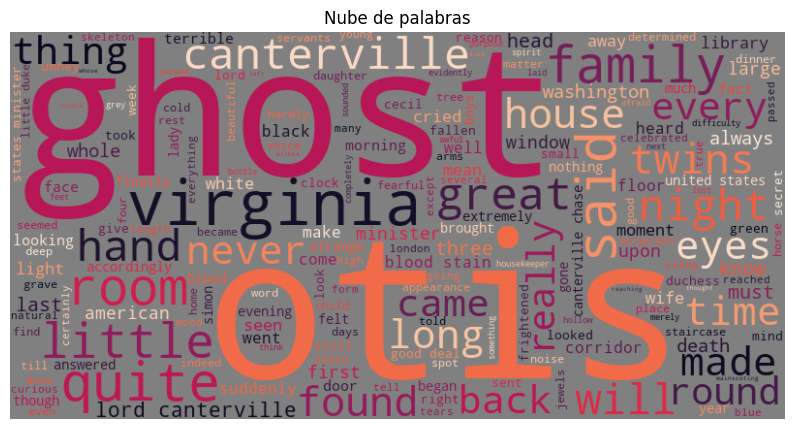

In [63]:
text = " ".join(df['sentence'])

tokens = re.findall(r'\b[a-záéíóúñ]{4,}\b', text)  
filtered_text = " ".join(tokens)

wordcloud = WordCloud(
    width=800, height=400,
    background_color="grey",   
    colormap="rocket"         
).generate(filtered_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

¿Cómo se distrubuyen los temas en la pieza?  

Conteo de escenas por capítulo y tema. 

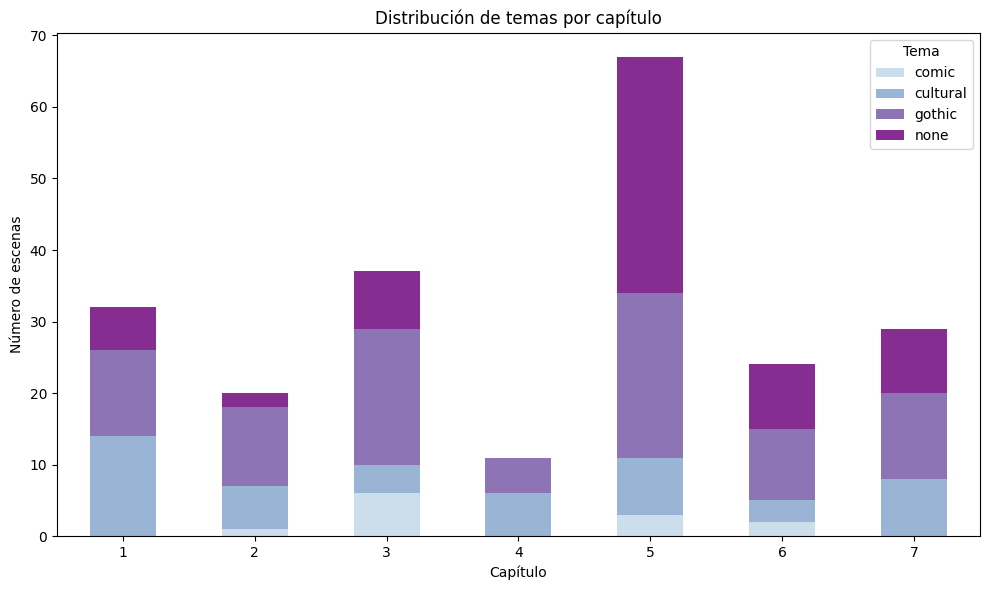

In [89]:
theme_distribution = df_scenes.groupby(["chapter","dominant_theme"]).size().unstack(fill_value=0)

colors = sns.color_palette("BuPu", n_colors=len(theme_distribution.columns))

theme_distribution.plot(
    kind="bar", stacked=True, figsize=(10,6), color=colors
)
plt.title("Distribución de temas por capítulo")
plt.xticks(rotation=0)  
plt.xlabel("Capítulo")
plt.ylabel("Número de escenas")
plt.legend(title="Tema")
plt.tight_layout()
plt.show()


¿Cómo se distribuyen las emociones dentro de cada tema (tono) narrativo?



In [65]:
# Crear tabla cruzada entre tema y emoción
theme_emotion = pd.crosstab(df_scenes["dominant_theme"], df_scenes["dominant_emotion"])
theme_emotion

dominant_emotion,negative,neutral,positive
dominant_theme,,,
comic,4,5,3
cultural,8,21,20
gothic,18,48,26
none,17,40,10


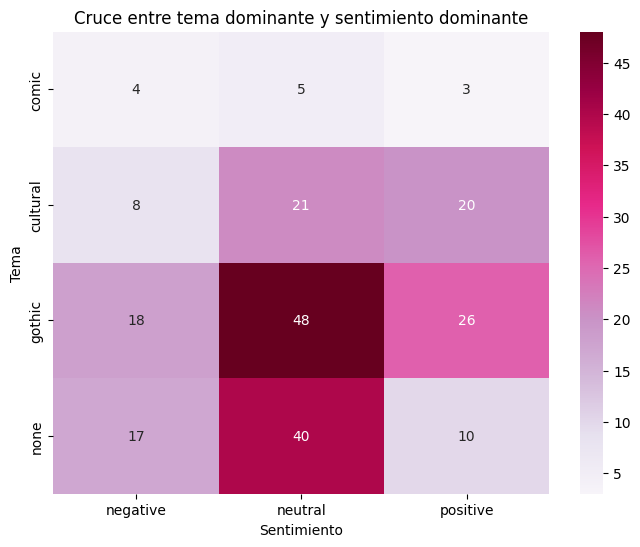

In [73]:
# Graficar heatmap
plt.figure(figsize=(8,6))
sns.heatmap(theme_emotion, annot=True, cmap="PuRd", fmt="d")

plt.title("Cruce entre tema dominante y sentimiento dominante")
plt.xlabel("Sentimiento")
plt.ylabel("Tema")
plt.show()


¿Cómo evolucionan la polaridad lexica a lo largo del cuento?

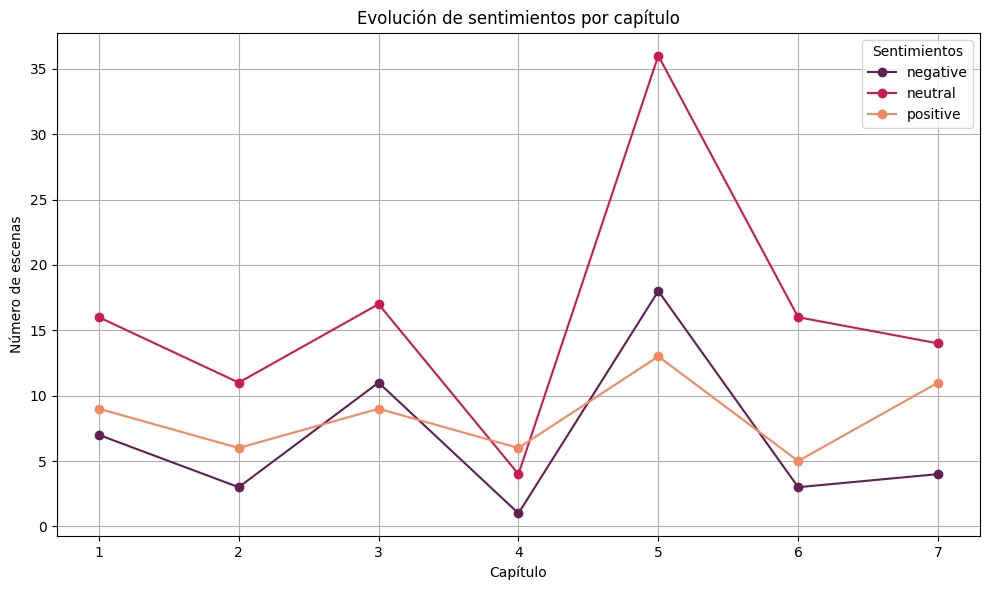

In [85]:
emotion_evolution = df_scenes.groupby(['chapter','dominant_emotion']).size().unstack(fill_value=0)

colors = sns.color_palette("rocket", n_colors=len(emotion_evolution.columns))
emotion_evolution.plot(
    kind='line', marker='o', figsize=(10,6), color=colors
)

plt.title('Evolución de sentimientos por capítulo')
plt.xlabel('Capítulo')
plt.ylabel('Número de escenas')
plt.legend(title='Sentimientos')
plt.grid(True)
plt.tight_layout()
plt.show()

¿Qué nos dice sobre el estilo?

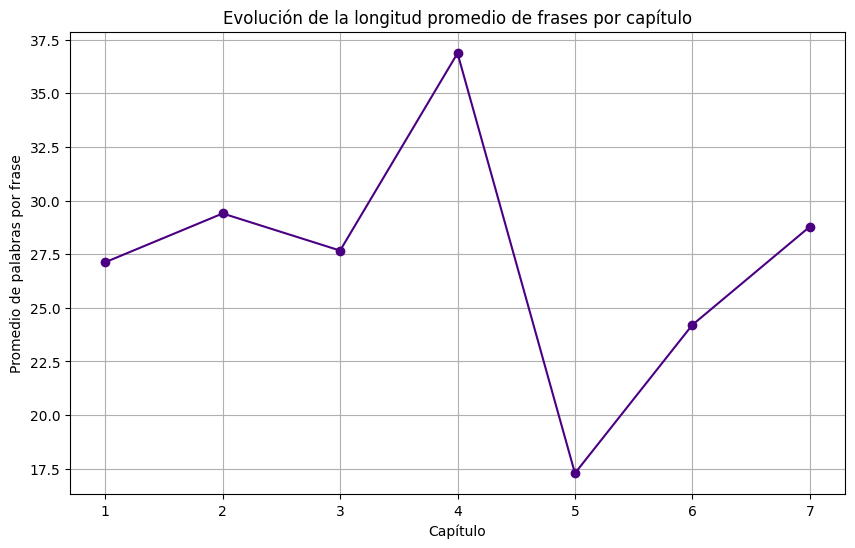

In [80]:
avg_length = df.groupby("chapter")["sentence_length_words"].mean()

avg_length.plot(kind="line", marker="o", color="#4B0082",figsize=(10,6))
plt.title("Evolución de la longitud promedio de frases por capítulo")
plt.xlabel("Capítulo")
plt.ylabel("Promedio de palabras por frase")
plt.grid(True)
plt.show()

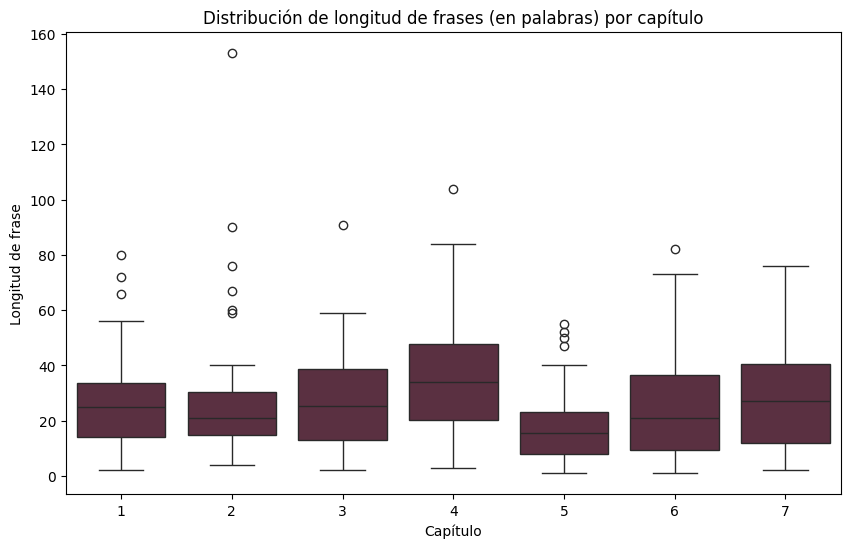

In [84]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="chapter", y="sentence_length_words", color ="#612940" )
plt.title("Distribución de longitud de frases (en palabras) por capítulo")
plt.xlabel("Capítulo")
plt.ylabel("Longitud de frase")
plt.show()

Para entender el estilo del autor. 

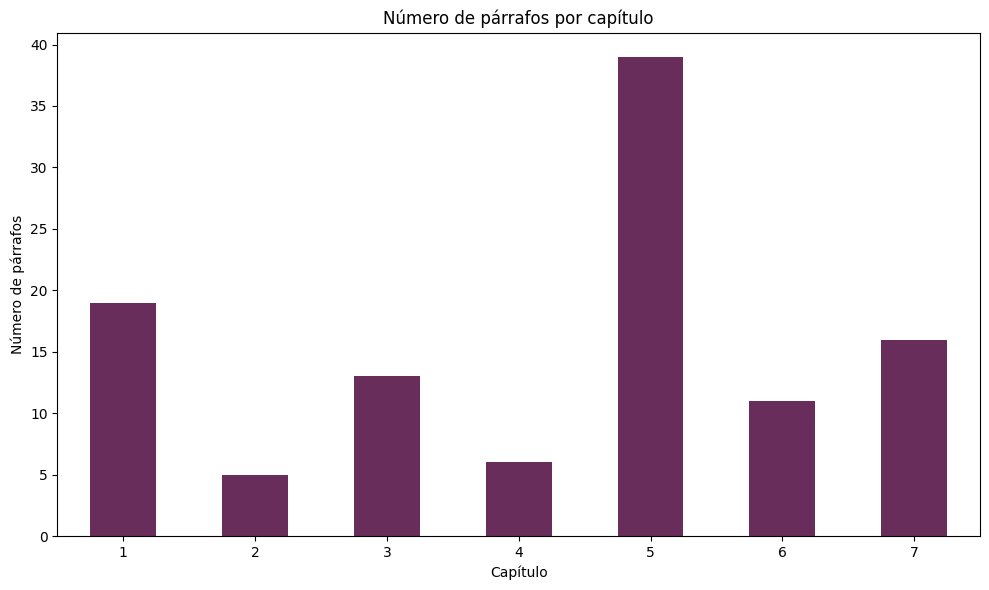

In [82]:

# Contar párrafos por capítulo
paragraph_counts = df.groupby("chapter")["paragraph"].nunique()

# Gráfico de barras
plt.figure(figsize=(10,6))
paragraph_counts.plot(kind="bar", color="#692D5B")

plt.title("Número de párrafos por capítulo")
plt.xlabel("Capítulo")
plt.ylabel("Número de párrafos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

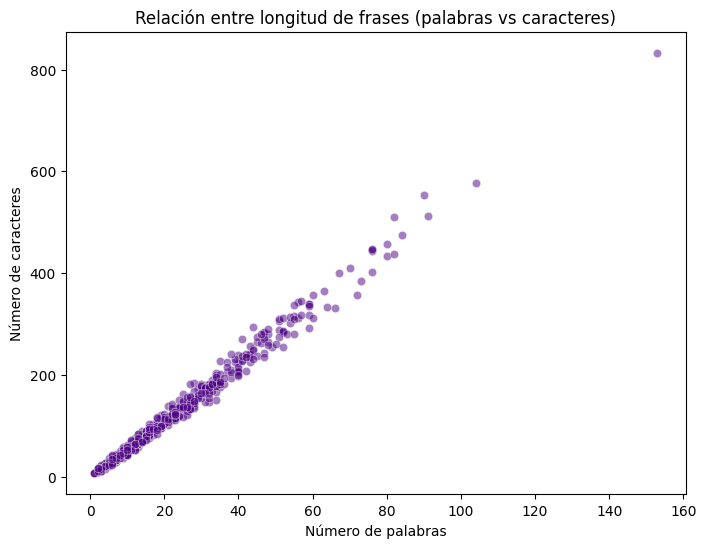

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="sentence_length_words", y="sentence_length_chars", alpha=0.5, color="#4B0082")
plt.title("Relación entre longitud de frases (palabras vs caracteres)")
plt.xlabel("Número de palabras")
plt.ylabel("Número de caracteres")
plt.show()


Red narrativa

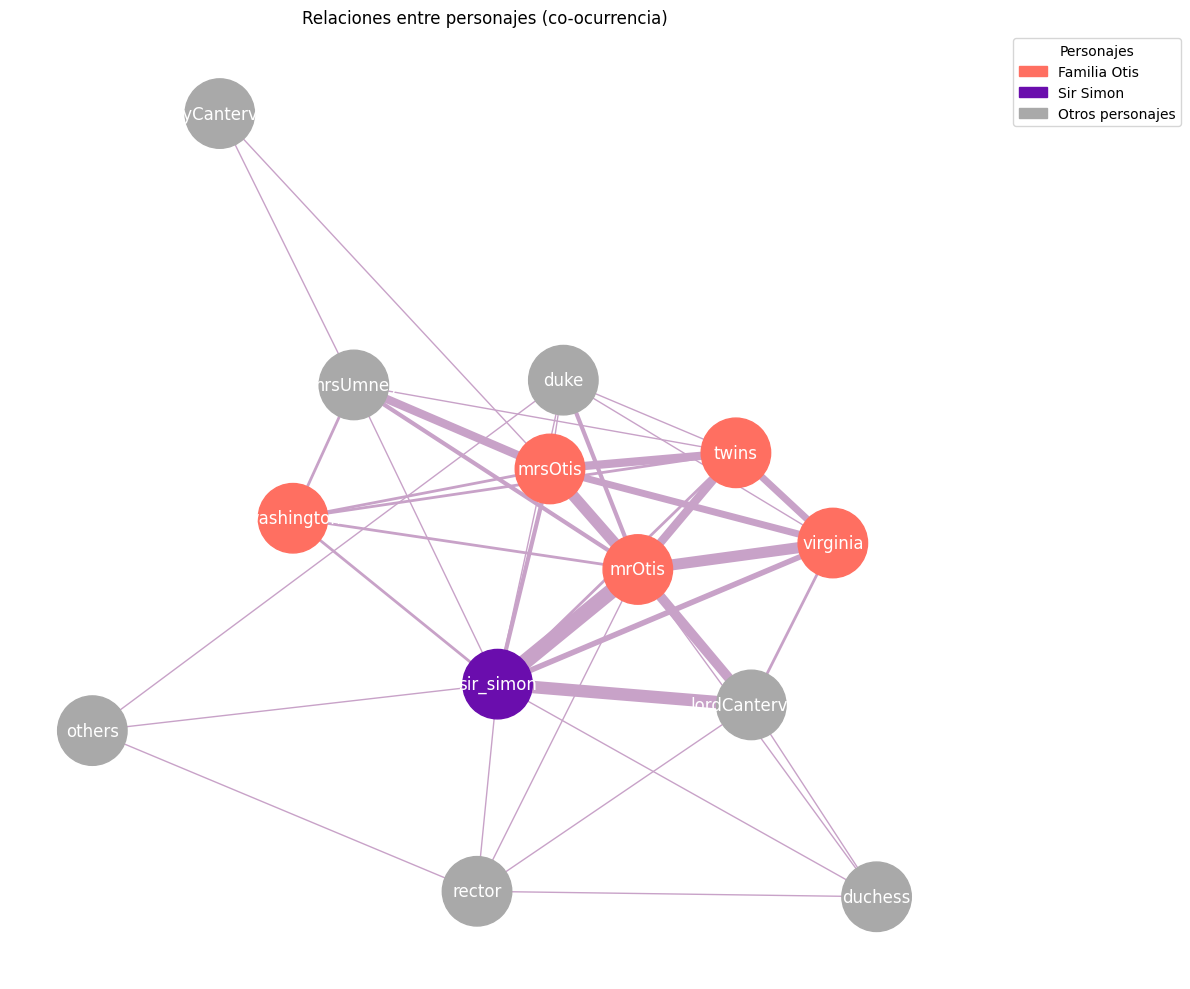

In [ ]:

G = nx.Graph()


for chars in df['characters']:
    if isinstance(chars, list):
        for pair in itertools.combinations(chars, 2):
            if G.has_edge(*pair):
                G[pair[0]][pair[1]]['weight'] += 1
            else:
                G.add_edge(pair[0], pair[1], weight=1)


pos = nx.spring_layout(G, k=0.5)


if "sir_simon" in pos:
    pos["sir_simon"][0] -= 0.1  
    pos["sir_simon"][1] -= 0.1  


familia_otis = ["mrOtis", "mrsOtis", "virginia", "washington", "twins"]
fantasma = ["sir_simon"]
otros = list(set(G.nodes()) - set(familia_otis) - set(fantasma))


color_familia = "#FF6F61"     
color_fantasma = "#6A0DAD"     
color_otros = "#A9A9A9"        

node_colors = {}
for node in G.nodes():
    if node in familia_otis:
        node_colors[node] = color_familia
    elif node in fantasma:
        node_colors[node] = color_fantasma
    else:
        node_colors[node] = color_otros

color_list = [node_colors[node] for node in G.nodes()]


edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]


plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=color_list, node_size=2500)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, edge_color="#C8A2C8")
nx.draw_networkx_labels(G, pos, font_size=12, font_color="white")


legend_handles = [
    mpatches.Patch(color=color_familia, label="Familia Otis"),
    mpatches.Patch(color=color_fantasma, label="Sir Simon"),
    mpatches.Patch(color=color_otros, label="Otros personajes")
]
plt.legend(handles=legend_handles, title="Personajes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Relaciones entre personajes (co-ocurrencia)")
plt.axis("off")
plt.tight_layout()
plt.show()
